In [1]:
# !sudo apt install swig

In [1]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'finrl'

# Data Import and Preprocessing

In [ ]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2011-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

In [ ]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [ ]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [ ]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3['net_export_goods_and_services'] = df_portfolio_comb_3['net_export_goods_and_services'].ffill()
df_portfolio_comb_3['exports_goods'] = df_portfolio_comb_3['exports_goods'].ffill()
df_portfolio_comb_3['exports_services'] = df_portfolio_comb_3['exports_services'].ffill()
df_portfolio_comb_3['imports_goods'] = df_portfolio_comb_3['imports_goods'].ffill()
df_portfolio_comb_3['imports_services'] = df_portfolio_comb_3['imports_services'].ffill()

df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [ ]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()
df_portfolio_comb_4['Book Value per Share'] = df_portfolio_comb_4['Book Value per Share'].ffill()
df_portfolio_comb_4['Net EPS'] = df_portfolio_comb_4['Net EPS'].ffill()
df_portfolio_comb_4['TTM Sales per Share'] = df_portfolio_comb_4['TTM Sales per Share'].ffill()
df_portfolio_comb_4['TTM Net Income (Billions)'] = df_portfolio_comb_4['TTM Net Income (Billions)'].ffill()
df_portfolio_comb_4['Shareholder\'s Equity (Billion)'] = df_portfolio_comb_4['Shareholder\'s Equity (Billion)'].ffill()


In [ ]:
## VMD
from vmdpy import VMD

def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    """Applies VMD to the 'close' price for each ticker in the dataframe
    and handles any length mismatch issues."""
    vmd_features = []
    
    # Apply VMD per ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Perform VMD on the close prices
        u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
        # Check if the lengths match, and if not, align them
        if u.shape[1] != len(tic_df):
            print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
            min_len = min(u.shape[1], len(tic_df))
            tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
            u = u[:, :min_len]  # Truncate VMD output if necessary
        
        # Assign VMD modes to columns
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = u[k, :]
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df
#apply VMD separately to each train, 2021, 2022, 2023 data
df_portfolio_comb_5 = apply_vmd_to_ticker(df_portfolio_comb_4)

In [ ]:
from vmdpy import VMD
import pandas as pd
import numpy as np

def apply_vmd_to_ticker_rolling(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7, window=365):
    """
    Applies VMD to the 'close' price for each ticker in the dataframe using a rolling window approach.
    This ensures that each VMD decomposition is based only on the previous `window` ticks, avoiding forward leakage.
    
    Args:
        df (pd.DataFrame): Dataframe containing 'close' price data and 'tic' column.
        alpha, tau, K, DC, init, tol: Parameters for the VMD decomposition.
        window (int): Number of previous ticks to use for the rolling VMD.

    Returns:
        pd.DataFrame: DataFrame with the VMD modes added for each ticker.
    """
    vmd_features = []
    
    # Apply VMD for each ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Initialize empty columns for VMD modes
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = np.nan  # Initialize with NaNs

        # Apply VMD in a rolling window manner
        for i in range(window, len(close_prices)):
            close_window = close_prices[i - window:i]  # Select the previous `window` close prices
            
            # Perform VMD on the window of close prices
            u, _, _ = VMD(close_window, alpha, tau, K, DC, init, tol)
            
            # Assign the latest VMD modes (from the last tick of the window) to the current row
            for k in range(K):
                tic_df.at[tic_df.index[i], f'vmd_mode_{k}'] = u[k, -1]  # Assign last mode from the VMD result
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

df_portfolio_comb_5 = apply_vmd_to_ticker_rolling(df_portfolio_comb_4)


In [ ]:
df_portfolio_final = df_portfolio_comb_5

In [ ]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

In [ ]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [ ]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [ ]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

In [ ]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "vmd_mode_0",
                                  "vmd_mode_1",
                                  "vmd_mode_2",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [60]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [61]:
# #save as parquet
# df_portfolio_train.to_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021.to_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022.to_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023.to_parquet('datasets/df_portfolio_2023.parquet')


## Load data and Initialise Packages
If loading data start here.

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load the data
df_portfolio_train = pd.read_parquet('datasets/df_portfolio_train.parquet')
df_portfolio_2021 = pd.read_parquet('datasets/df_portfolio_2021.parquet')
df_portfolio_2022 = pd.read_parquet('datasets/df_portfolio_2022.parquet')
df_portfolio_2023 = pd.read_parquet('datasets/df_portfolio_2023.parquet')

In [62]:
df_portfolio_2021.head()

,date,tic,close,vmd_mode_0,vmd_mode_1,vmd_mode_2,high,low,High_VIX,Low_VIX,...,ics,TTM Revenue(Billion),TTM EBITDA(Billion),EBITDA Margin,Price to Book Ratio,PE Ratio,Price to Sales Ratio,Assets,NetIncomeLoss,Return on Equity(%)
25170,2021-01-04,AAPL,0.641887,0.653408,0.028011,0.034006,0.669322,0.643452,0.341523,0.320591,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25180,2021-01-05,AAPL,0.649823,0.655796,0.008921,0.103098,0.659954,0.651929,0.334620,0.352423,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25190,2021-01-06,AAPL,0.627949,0.656645,-0.025514,-0.199399,0.656497,0.641523,0.313209,0.314623,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25200,2021-01-07,AAPL,0.649376,0.658042,-0.038440,0.138966,0.659403,0.649036,0.279747,0.316186,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25210,2021-01-08,AAPL,0.654981,0.657464,-0.055837,-0.065949,0.664412,0.661066,0.273078,0.304391,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357


# Feature Selection and DRL Model Parameters

In feature_selection.ipynb, we perform a regression of parameters on close prices with LassoCV, and then inspect the coefficients to make a preliminary selection of the most efficient subset of features to include in our DRL model.

The selected features are: 

- High_VIX, Low_VIX, High_SPY, Low_SPY, Close_SPY, 
- Fear Greed, ratingScore, ratingDetailsROEScore, 
- exports, pound_dollar_exchange_rate, unemployment, ics,
- TTM Revenue(Billion), Price to Book Ratio, Price to Sales Ratio, Return on Equity(%)

In [80]:
FEATURE_NAMES = ["close",
                "vmd_mode_0",
                "vmd_mode_1",
                "vmd_mode_2",
                  #"high", 
                  #"low",
                'High_VIX',
                'Low_VIX',
                  #'Close_VIX',
                'High_SPY',
                'Low_SPY',
                'Close_SPY',
                  #'Volume_SPY',
                'Fear Greed', 
                'ratingScore',
                  #'ratingDetailsDCFScore',
                'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                'exports', 
                  #'imports',
                'pound_dollar_exchange_rate', 
                'unemployment',
                'ics',
                'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  #'EBITDA Margin',
                'Price to Book Ratio',
                  #'PE Ratio',
                'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                'Return on Equity(%)']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 5
CONV_MID = 5
CONV_FINAL= 20

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2011- Dec 2020)

In [73]:
DRLAgent.train_model(EIIE_model, episodes=15)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 389324.8125
Final accumulative portfolio value: 3.893248125
Maximum DrawDown: -0.33006971671714713
Sharpe ratio: 0.8706379480796932


  7%|▋         | 1/15 [00:13<03:04, 13.19s/it]

Initial portfolio value:100000
Final portfolio value: 853120.3125
Final accumulative portfolio value: 8.531203125
Maximum DrawDown: -0.31895105851166106
Sharpe ratio: 1.1299880809837735


 13%|█▎        | 2/15 [00:26<02:53, 13.32s/it]

Initial portfolio value:100000
Final portfolio value: 1608982.5
Final accumulative portfolio value: 16.089825
Maximum DrawDown: -0.3849888297351025
Sharpe ratio: 1.236796856433713


 20%|██        | 3/15 [00:39<02:39, 13.31s/it]

Initial portfolio value:100000
Final portfolio value: 1969771.125
Final accumulative portfolio value: 19.69771125
Maximum DrawDown: -0.38505779293477727
Sharpe ratio: 1.2874760282977895


 27%|██▋       | 4/15 [00:52<02:23, 13.09s/it]

Initial portfolio value:100000
Final portfolio value: 1892357.0
Final accumulative portfolio value: 18.92357
Maximum DrawDown: -0.38515175431306214
Sharpe ratio: 1.2742373826406421


 33%|███▎      | 5/15 [01:05<02:09, 13.00s/it]

Initial portfolio value:100000
Final portfolio value: 2149917.0
Final accumulative portfolio value: 21.49917
Maximum DrawDown: -0.3851222426954336
Sharpe ratio: 1.335289915317312


 40%|████      | 6/15 [01:18<01:56, 12.97s/it]

Initial portfolio value:100000
Final portfolio value: 1838920.75
Final accumulative portfolio value: 18.3892075
Maximum DrawDown: -0.3851581936580518
Sharpe ratio: 1.246477398120234


 47%|████▋     | 7/15 [01:31<01:43, 12.97s/it]

Initial portfolio value:100000
Final portfolio value: 2009118.625
Final accumulative portfolio value: 20.09118625
Maximum DrawDown: -0.38515822582308623
Sharpe ratio: 1.2745176180964424


 53%|█████▎    | 8/15 [01:44<01:30, 12.91s/it]

Initial portfolio value:100000
Final portfolio value: 2703721.0
Final accumulative portfolio value: 27.03721
Maximum DrawDown: -0.38515942827977045
Sharpe ratio: 1.3888429366012214


 60%|██████    | 9/15 [01:57<01:17, 12.97s/it]

Initial portfolio value:100000
Final portfolio value: 2676204.75
Final accumulative portfolio value: 26.7620475
Maximum DrawDown: -0.3851609544954804
Sharpe ratio: 1.3835689008721999


 67%|██████▋   | 10/15 [02:10<01:05, 13.04s/it]

Initial portfolio value:100000
Final portfolio value: 2457283.5
Final accumulative portfolio value: 24.572835
Maximum DrawDown: -0.38582311596162056
Sharpe ratio: 1.3465537067036837


 73%|███████▎  | 11/15 [02:23<00:52, 13.09s/it]

Initial portfolio value:100000
Final portfolio value: 2878998.0
Final accumulative portfolio value: 28.78998
Maximum DrawDown: -0.38516292946497965
Sharpe ratio: 1.4454833993812468


 80%|████████  | 12/15 [02:36<00:39, 13.16s/it]

Initial portfolio value:100000
Final portfolio value: 3136764.75
Final accumulative portfolio value: 31.3676475
Maximum DrawDown: -0.38515924932754264
Sharpe ratio: 1.4214236960785043


 87%|████████▋ | 13/15 [02:50<00:26, 13.19s/it]

Initial portfolio value:100000
Final portfolio value: 1995201.5
Final accumulative portfolio value: 19.952015
Maximum DrawDown: -0.38515917950838874
Sharpe ratio: 1.2567413709025346


 93%|█████████▎| 14/15 [03:03<00:13, 13.30s/it]

Initial portfolio value:100000
Final portfolio value: 1994305.0
Final accumulative portfolio value: 19.94305
Maximum DrawDown: -0.3851590457603773
Sharpe ratio: 1.260834992582611


100%|██████████| 15/15 [03:18<00:00, 13.21s/it]


# DRL Model Evaluation (Jan 2021-Dec 2023)

In [74]:
import os
import shutil

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_76737/422646042.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("polic

<All keys matched successfully>

In [75]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', '2021_portfolio_value', '2022_portfolio_value', '2023_portfolio_value',
        'train_drawdown', '2021_drawdown', '2022_drawdown', '2023_drawdown',
        'train_sharpe', '2021_sharpe', '2022_sharpe', '2023_sharpe',
        'train_cumulative', '2021_cumulative', '2022_cumulative', '2023_cumulative']

results_df = pd.DataFrame(columns=columns)

In [76]:
environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(environment)

src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory
portfolio_2021_value, drawdown_2021, sharpe_2021, cumulative_2021 = calculate_metrics(environment_2021)

src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory
portfolio_2022_value, drawdown_2022, sharpe_2022, cumulative_2022 = calculate_metrics(environment_2022)

src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory
portfolio_2023_value, drawdown_2023, sharpe_2023, cumulative_2023 = calculate_metrics(environment_2023)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "2021": {"value": [], "actions": []},
    "2022": {"value": [], "actions": []},
    "2023": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
    UBAH_results["2021"]["actions"].append(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
    UBAH_results["2022"]["actions"].append(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
    UBAH_results["2023"]["actions"].append(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]


Initial portfolio value:100000
Final portfolio value: 1639191.125
Final accumulative portfolio value: 16.39191125
Maximum DrawDown: -0.4000704111227916
Sharpe ratio: 1.2071696729168293
Initial portfolio value:100000
Final portfolio value: 124892.765625
Final accumulative portfolio value: 1.24892765625
Maximum DrawDown: -0.1527401183986662
Sharpe ratio: 1.380827503434819
Initial portfolio value:100000
Final portfolio value: 106193.6796875
Final accumulative portfolio value: 1.061936796875
Maximum DrawDown: -0.26749494645665683
Sharpe ratio: 0.401885268223515
Initial portfolio value:100000
Final portfolio value: 133920.375
Final accumulative portfolio value: 1.33920375
Maximum DrawDown: -0.12026286231178662
Sharpe ratio: 1.9057195668987639
Initial portfolio value:100000
Final portfolio value: 367373.8125
Final accumulative portfolio value: 3.673738125
Maximum DrawDown: -0.35322276312956347
Sharpe ratio: 0.8227933691554483
Initial portfolio value:100000
Final portfolio value: 126713.60937

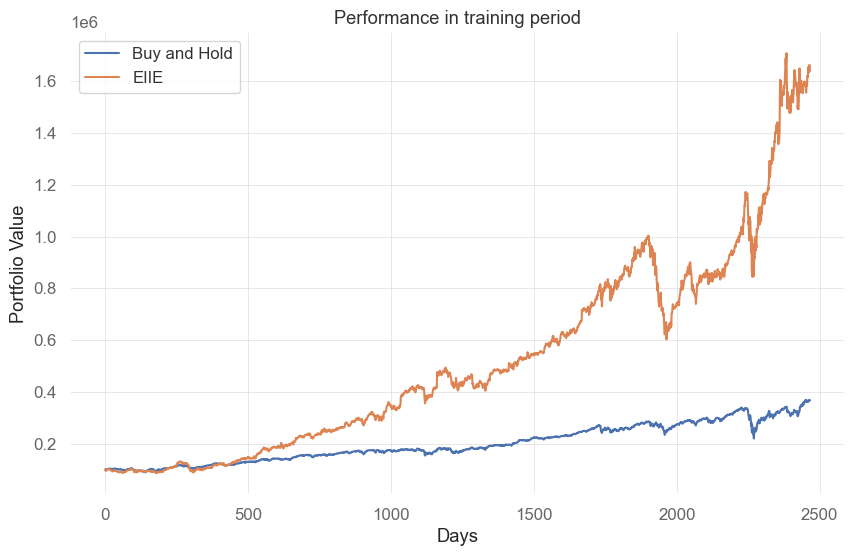

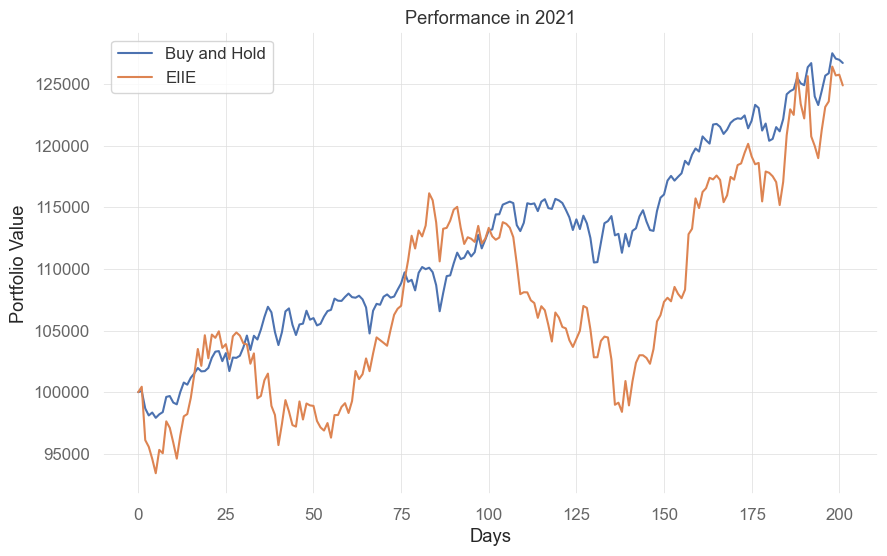

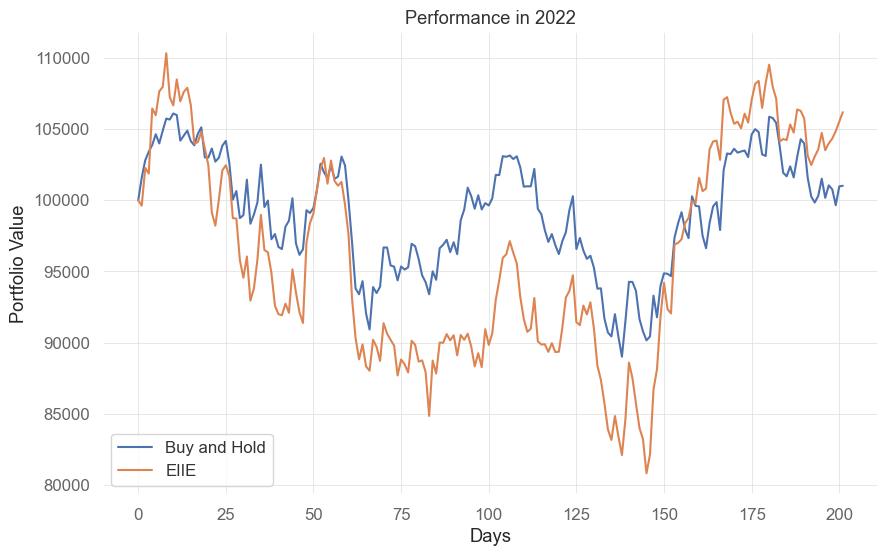

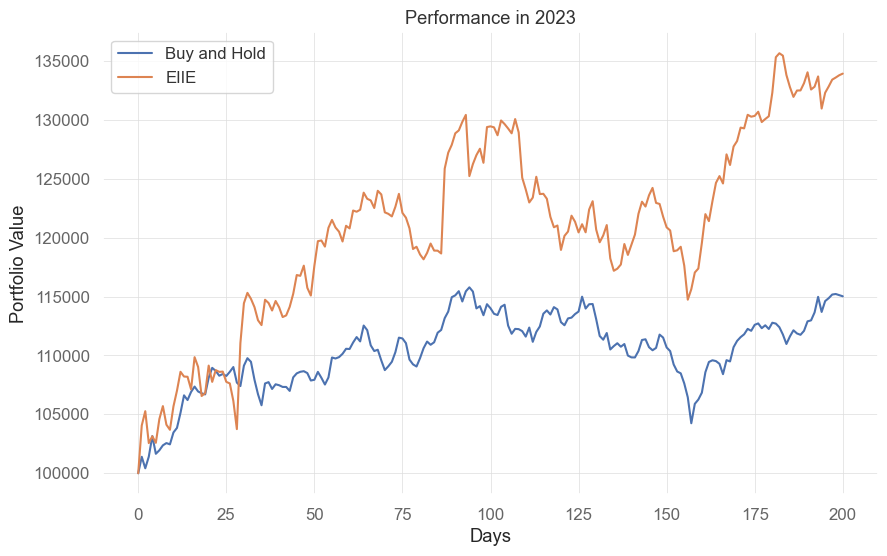

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
#plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
#plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

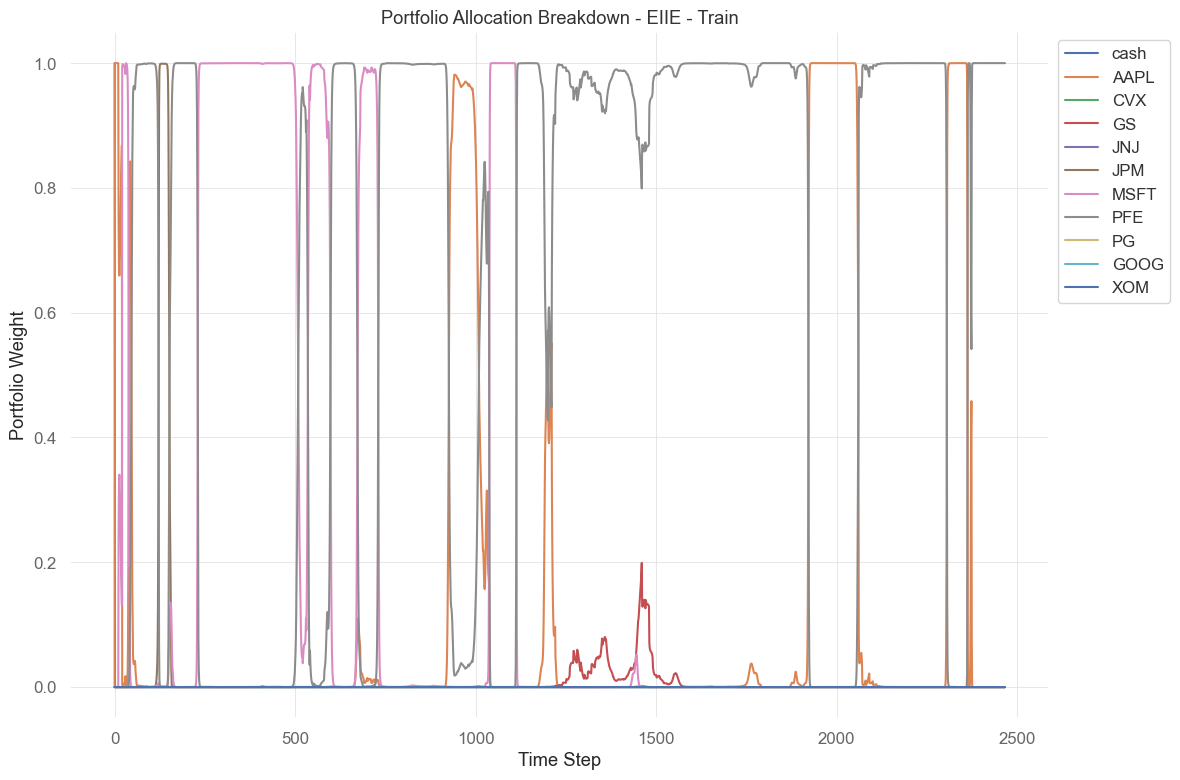

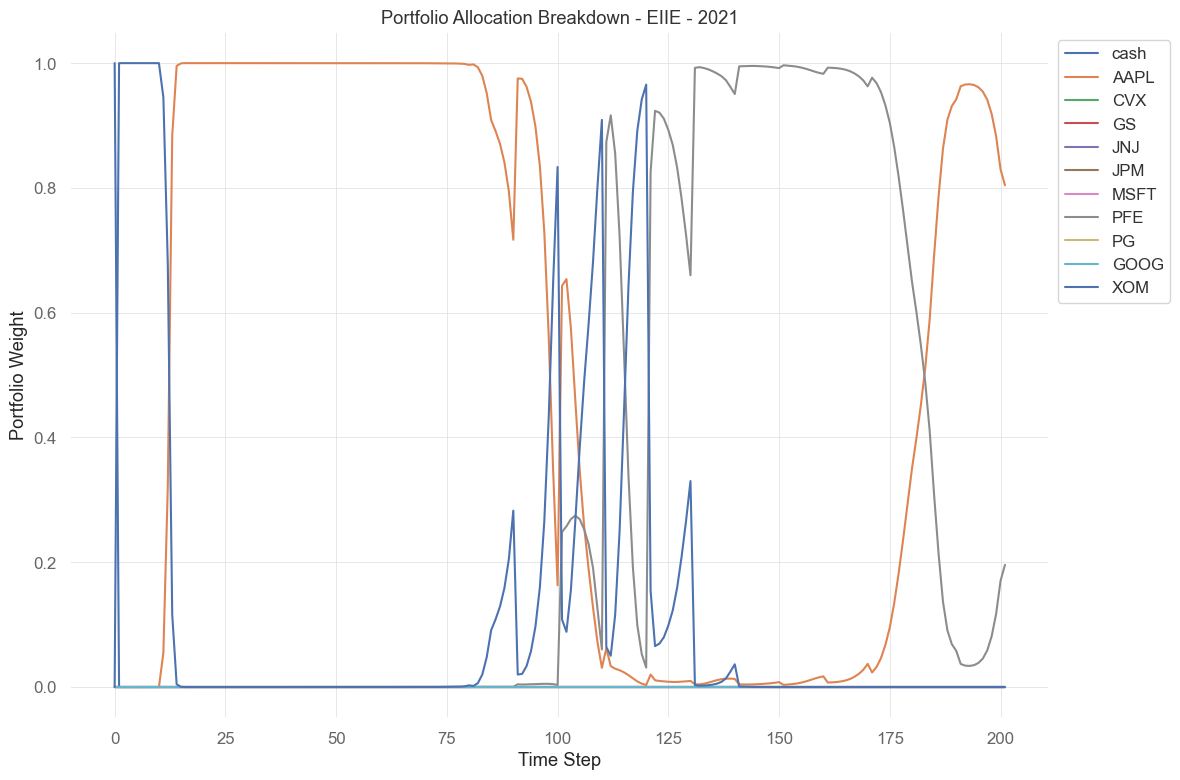

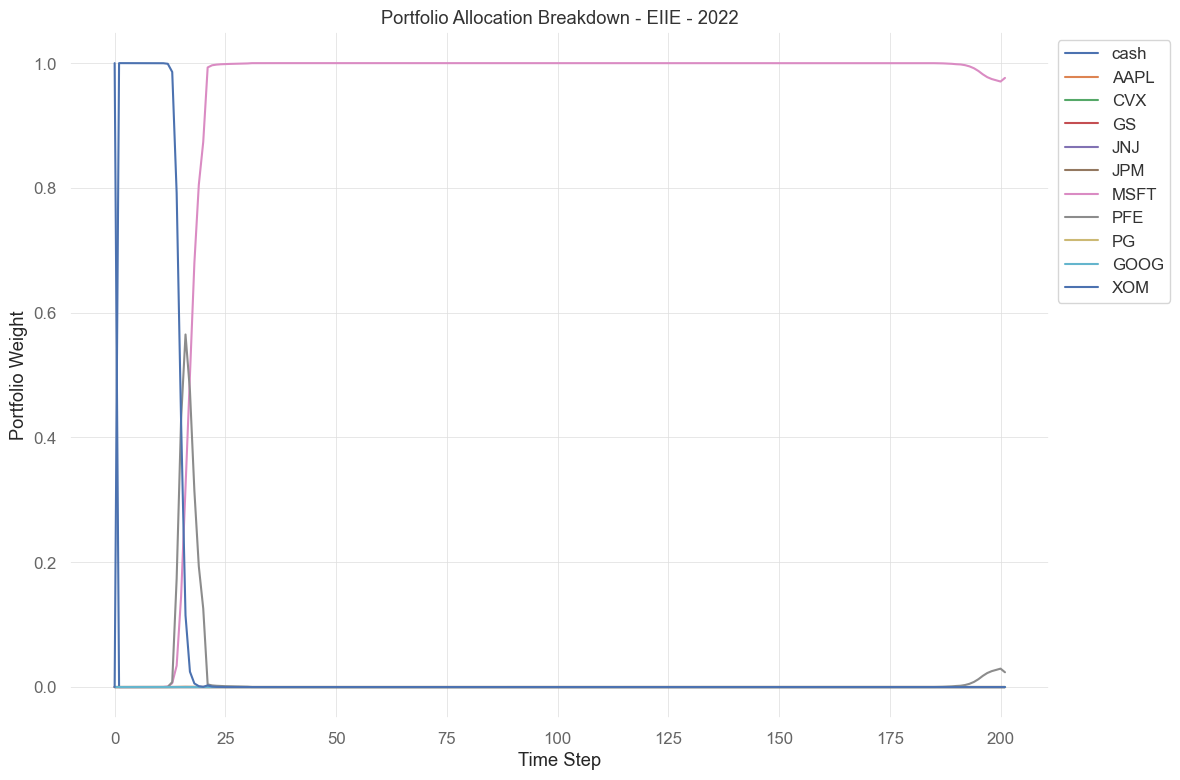

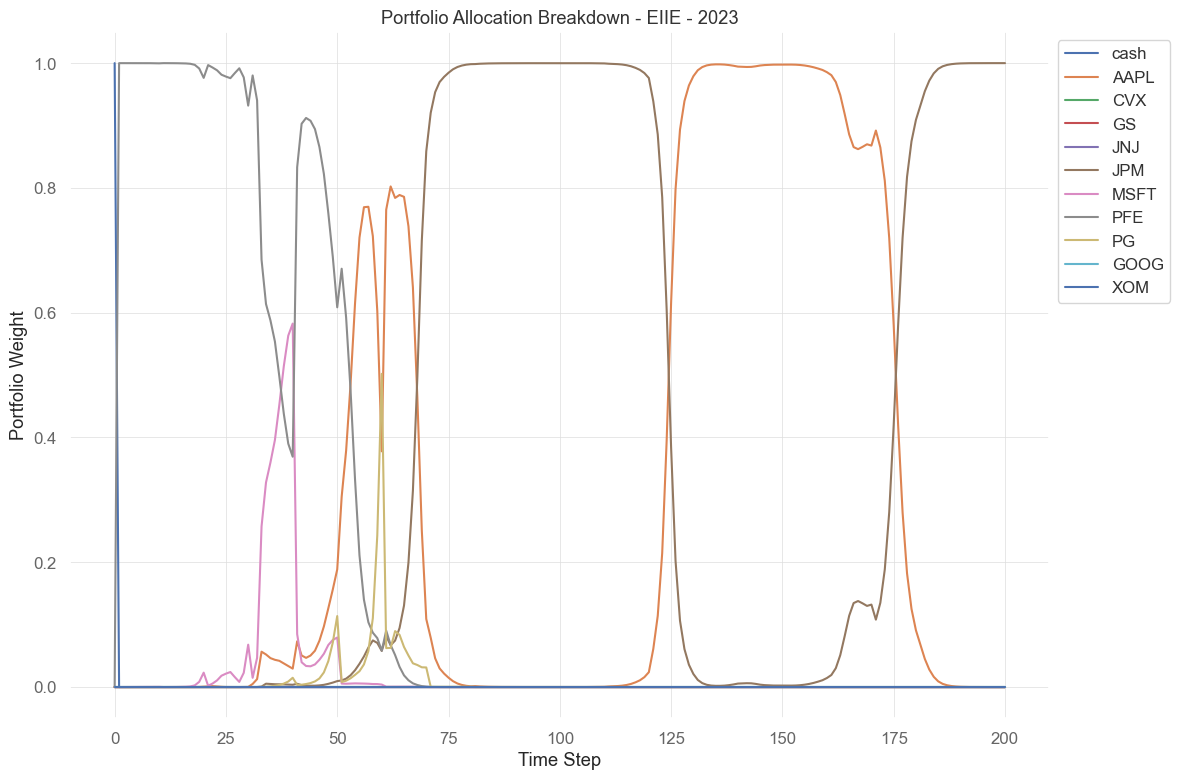

In [78]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

In [79]:
temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "2021_portfolio_value": portfolio_2021_value, "2021_drawdown": drawdown_2021, "2021_sharpe": sharpe_2021, "2021_cumulative": cumulative_2021,
        "2022_portfolio_value": portfolio_2022_value, "2022_drawdown": drawdown_2022, "2022_sharpe": sharpe_2022, "2022_cumulative": cumulative_2022,
        "2023_portfolio_value": portfolio_2023_value, "2023_drawdown": drawdown_2023, "2023_sharpe": sharpe_2023, "2023_cumulative": cumulative_2023
    }])
    
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_76737/3317322918.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,2021_portfolio_value,2022_portfolio_value,2023_portfolio_value,train_drawdown,2021_drawdown,2022_drawdown,2023_drawdown,train_sharpe,2021_sharpe,2022_sharpe,2023_sharpe,train_cumulative,2021_cumulative,2022_cumulative,2023_cumulative
0,50,5,5,20,1639191.125,124892.765625,106193.679688,133920.375,-0.40007,-0.15274,-0.267495,-0.120263,1.207661,1.387722,0.403886,1.915319,16.391911,1.248928,1.061937,1.339204


In [48]:
results_df.to_csv('filename.csv', index=False)